# After Funding
* Funding이 시작되기 전에는 예측이 어려웠다면 Funding이 시작된 이후에는 예측을 할 수 있을까?
* Funding이 시작된 이후 5일까지 각 날짜별로 얼마만큼의 금액이 펀딩되어야 최종적으로 성공할 것인지 예측
* Attributes : ***Target, Duration, Grammar_level, day_funding_rate, day_comment***
* Models : ***RandomForest, KNN, GaussianNB***

## 가정

* 일반적으로 생각하는 평균 펀딩액은 의미가 없을 것임.
* 초기 펀딩률의 중요성 파악 가능

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from time import time
import patsy

In [2]:
wadiz_df_original = pd.read_csv('wadiz_df_0329_1.csv', index_col=0)
user_comment = pd.read_csv('user_data_all_0329.csv', index_col=0)
provider_comment = pd.read_csv('provider_data_all_0329.csv', index_col=0)
wadiz_df = pd.read_csv('wadiz_provider_analysis_0329.csv', index_col=0)
provider_comment_grammar = pd.read_csv('comment_analysis.csv', index_col=0)

In [3]:
# grammar null값 제거
wadiz_df = wadiz_df[wadiz_df['provider_grammar_level'].notnull()]
# duration 처리
wadiz_df['date_duration'] = wadiz_df['date_duration'].apply(lambda x: int(x[:-24]))

## 1. Distribution Test

(-0.5, 1)

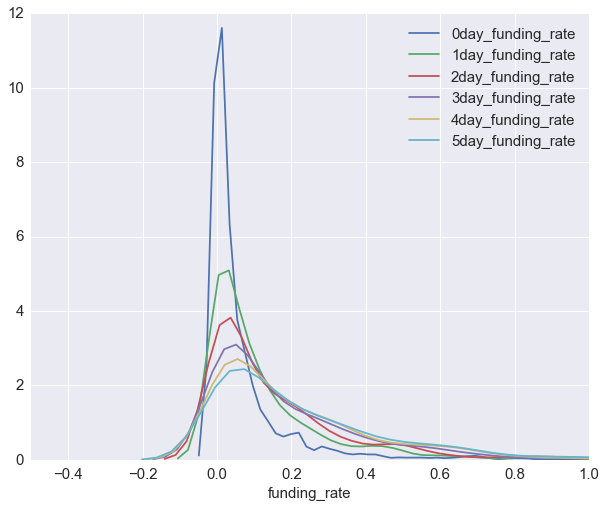

In [4]:
# 0~5일 이내 누적 펀딩율 분포 Graph
plt.figure(figsize=(10,8))
for i in np.arange(6):
    number = i
    sns.kdeplot(wadiz_df["{number}day_funding_rate".format(number = i)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('funding_rate', fontsize=15)
plt.ylabel('', fontsize=15)
plt.legend(fontsize = 15)
plt.xlim(-0.5, 1)

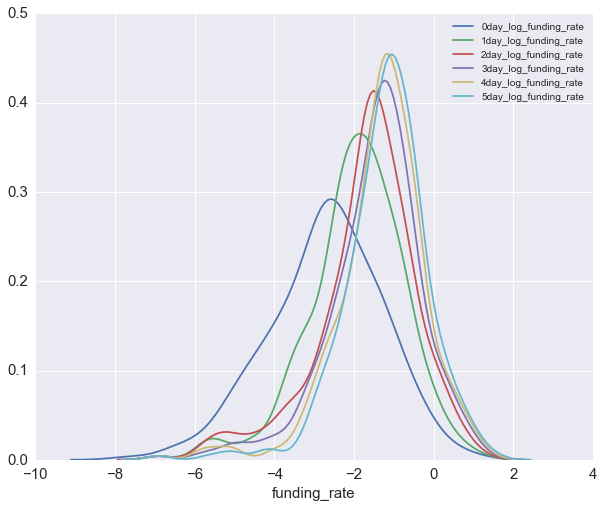

In [5]:
# funding_rate log scaling -> 소수점 이하 미미한 차이들을 확연히 확인 가능
# 성공 Projects의 날짜별 펀딩율 분포
plt.figure(figsize=(10,8))
for i in np.arange(6):
    number = i
    sns.kdeplot(wadiz_df.loc[wadiz_df['success'] == 1]["{number}day_log_funding_rate".format(number = i)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('funding_rate', fontsize=15)
plt.ylabel('', fontsize=15)
plt.legend(fontsize = 10)

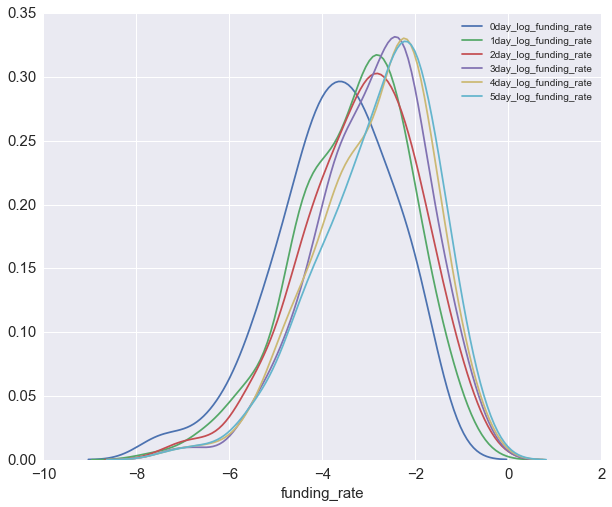

In [6]:
# 실패 Projects의 날짜별 펀딩율 분포
plt.figure(figsize=(10,8))
for i in np.arange(6):
    number = i
    sns.kdeplot(wadiz_df.loc[wadiz_df['success'] == 0]["{number}day_log_funding_rate".format(number = i)])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('funding_rate', fontsize=15)
plt.ylabel('', fontsize=15)
plt.legend(fontsize = 10)

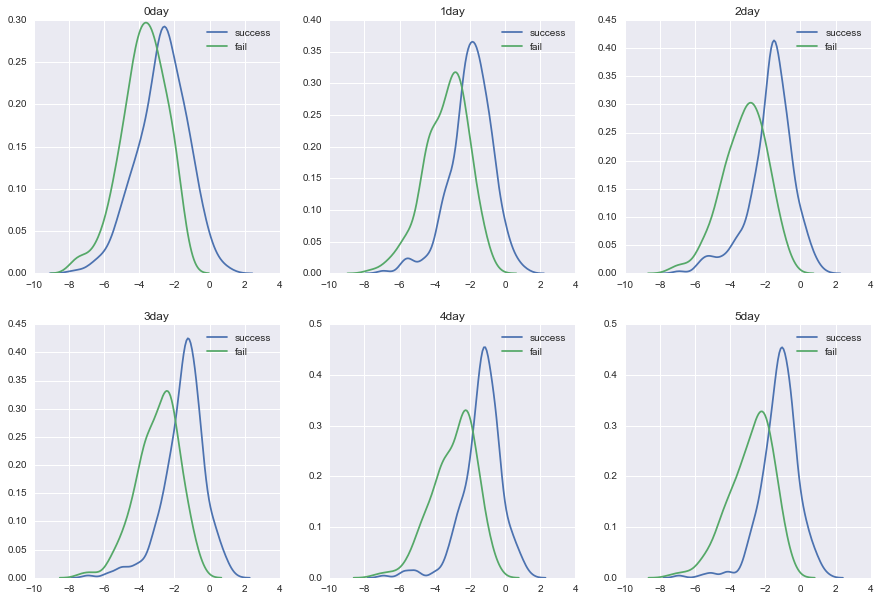

In [7]:
f, ax = plt.subplots(2, 3, figsize=(15,10))
for i in range(0, 6):
    if i < 3:
        sns.kdeplot(wadiz_df.loc[wadiz_df["success"] == 1]["{number}day_log_funding_rate".format(number = i)], 
                    label = 'success', ax=ax[0,i])
        sns.kdeplot(wadiz_df.loc[wadiz_df["success"] == 0]["{number}day_log_funding_rate".format(number = i)], 
                    label = 'fail', ax=ax[0,i])
        ax[0,i].set_title("{number}day".format(number = i))
    else:
        sns.kdeplot(wadiz_df.loc[wadiz_df["success"] == 1]["{number}day_log_funding_rate".format(number = i)], 
                    label = 'success', ax=ax[1,i-3])
        sns.kdeplot(wadiz_df.loc[wadiz_df["success"] == 0]["{number}day_log_funding_rate".format(number = i)], 
                    label = 'fail', ax=ax[1,i-3])
        ax[1,i-3].set_title("{number}day".format(number = i))

In [8]:
# Ks_2sampResult : Kolmogorov-Smirnov test (분포차이 검정)
# Ttest_indResult : 2 sample T-test(평균차이 검정)
for i in range(0,6):
    success_funding_rate = wadiz_df.loc[wadiz_df["success"] == 1]["{number}day_funding_rate".format(number = i)]
    fail_funding_rate = wadiz_df.loc[wadiz_df["success"] == 0]["{number}day_funding_rate".format(number = i)]
    print('[{number}day_success vs {number}day_fail]'.format(number = i)), 
    print('  K-S statistic :', round(sp.stats.ks_2samp(success_funding_rate, fail_funding_rate)[0], 4))
    print('  p-value :', round(sp.stats.ks_2samp(success_funding_rate, fail_funding_rate)[1], 4))

[0day_success vs 0day_fail]
  K-S statistic : 0.3677
  p-value : 0.0
[1day_success vs 1day_fail]
  K-S statistic : 0.4948
  p-value : 0.0
[2day_success vs 2day_fail]
  K-S statistic : 0.541
  p-value : 0.0
[3day_success vs 3day_fail]
  K-S statistic : 0.5624
  p-value : 0.0
[4day_success vs 4day_fail]
  K-S statistic : 0.6004
  p-value : 0.0
[5day_success vs 5day_fail]
  K-S statistic : 0.5992
  p-value : 0.0


In [9]:
# T-teest : 평균 차이 검정
for i in range(0,6):
    success_funding_rate = wadiz_df.loc[wadiz_df["success"] == 1]["{number}day_funding_rate".format(number = i)]
    fail_funding_rate = wadiz_df.loc[wadiz_df["success"] == 0]["{number}day_funding_rate".format(number = i)]
    print('[{number}day_success vs {number}day_fail]'.format(number = i)), 
    print('  T-test statistic :', round(sp.stats.ttest_ind(success_funding_rate, fail_funding_rate)[0], 4))
    print('  p-value :', round(sp.stats.ttest_ind(success_funding_rate, fail_funding_rate)[1], 4))

[0day_success vs 0day_fail]
  T-test statistic : 6.9219
  p-value : 0.0
[1day_success vs 1day_fail]
  T-test statistic : 9.3425
  p-value : 0.0
[2day_success vs 2day_fail]
  T-test statistic : 10.5788
  p-value : 0.0
[3day_success vs 3day_fail]
  T-test statistic : 11.0987
  p-value : 0.0
[4day_success vs 4day_fail]
  T-test statistic : 11.6594
  p-value : 0.0
[5day_success vs 5day_fail]
  T-test statistic : 11.8647
  p-value : 0.0


* 성공/실패 프로젝트들의 펀딩 시작 후 분포는 확연히 다른 분포임을 확인
* 초기 5일 이내 펀딩율로 프로젝트의 성공 여부 판단 가능할 것으로 기대

## 2. Classification
* Features_1 : Target, Duration, Grammar_level, (0~5)Day_funding_rate
* Features_2 : (0~5)Day_funding_rate

### A. RandomForest

In [10]:
re = RandomForestClassifier()

In [11]:
x_classification_1day = pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['1day_funding_rate']]).T
y = wadiz_df['success']
x_re_list_1 = []
y_re_list_1 = []

for i in range(1, 100):
    re_1 = RandomForestClassifier(n_estimators=i)
    a = cross_val_score(re_1, x_classification_1day, y, cv=10)
    b = a.sum() / 10
    #print(b)
    x_re_list_1.append(i)
    y_re_list_1.append(b)

base_success_rate : 52.18 %
max_accuracy : 73.87 %


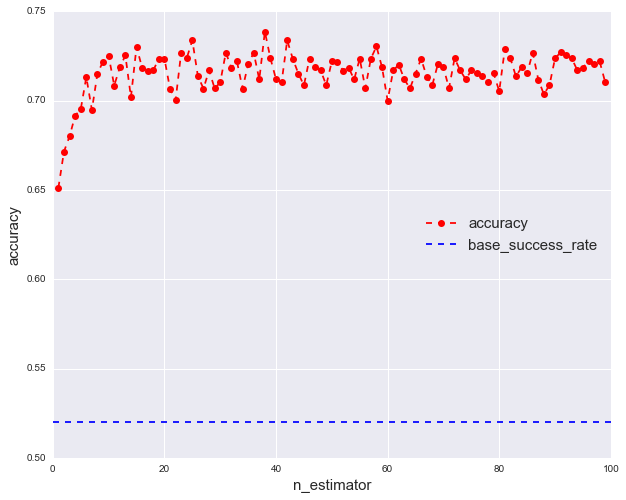

In [12]:
# tree개수의 변화에 따른 accuracy 변화
base_success_rate = round((y.value_counts()[1] / len(y)), 2)
figure = plt.figure(figsize=(10,8))
plt.plot(x_re_list_1, y_re_list_1, 'o--', c = 'r', label = 'accuracy')
plt.axhline(base_success_rate, ls = '--', label = 'base_success_rate')
plt.legend(fontsize=15, loc=7)
plt.xlabel('n_estimator', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
#plt.ylim(0.50, 0.68)
print('base_success_rate :', round((y.value_counts()[1] / len(y))*100, 2), '%')
print('max_accuracy :', round(max(y_re_list_1)*100, 2), '%')

### B. Grid Search 

In [13]:
# Gridsearch report를 위한 함수 생성
from operator import itemgetter
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [14]:
#grid search
param_grid = {"max_depth": [5, 10, None],
              "max_features": [1, 3, None],
              "min_samples_split": [1, 3, 5],
              "min_samples_leaf": [1, 3, 5, 10],
              "n_estimators" : np.arange(3, 20)}

# run grid search
grid_search = GridSearchCV(re, param_grid=param_grid)
start = time
grid_search.fit(x_classification_1day, y)

#print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#      % ((time() - start), len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.753 (std: 0.043)
Parameters: {'min_samples_split': 5, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 6}

Model with rank: 2
Mean validation score: 0.750 (std: 0.039)
Parameters: {'min_samples_split': 1, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 19}

Model with rank: 3
Mean validation score: 0.750 (std: 0.041)
Parameters: {'min_samples_split': 1, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 9}



In [15]:
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.753 (std: 0.043)
Parameters: {'min_samples_split': 5, 'max_depth': 5, 'max_features': 3, 'min_samples_leaf': 1, 'n_estimators': 6}

Model with rank: 2
Mean validation score: 0.750 (std: 0.039)
Parameters: {'min_samples_split': 1, 'max_depth': 5, 'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 19}

Model with rank: 3
Mean validation score: 0.750 (std: 0.041)
Parameters: {'min_samples_split': 1, 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 9}



In [16]:
best_re_day = RandomForestClassifier(max_features= 1, max_depth= None, min_samples_split= 3, n_estimators= 19, min_samples_leaf= 10)

### C. Cross_Validation

Best_Score_0day_mean :  67.0 %
Best_Score_0day_std :  0.0665
Best_Score_1day_mean :  73.36 %
Best_Score_1day_std :  0.0632
Best_Score_2day_mean :  75.53 %
Best_Score_2day_std :  0.0759
Best_Score_3day_mean :  76.2 %
Best_Score_3day_std :  0.067
Best_Score_4day_mean :  78.54 %
Best_Score_4day_std :  0.0666
Best_Score_5day_mean :  77.88 %
Best_Score_5day_std :  0.048


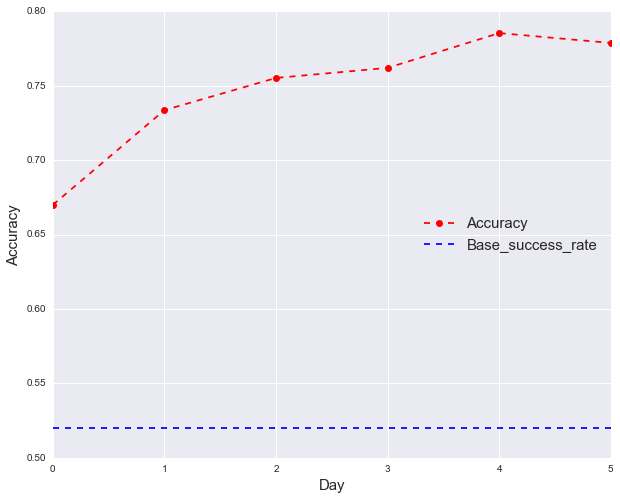

In [17]:
# 각 일자별 RandomForest Score
Stkfold = StratifiedKFold(y, n_folds=10)
y_day_list = []
x_day_list = []
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)
    print('Best_Score_{number}day_mean : '.format(number=i), round(score_cv_mean*100, 2), '%')
    print('Best_Score_{number}day_std : '.format(number=i), round(score_cv_std, 4))
    print('========================================')

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);

In [18]:
best_re_day.fit(x_classification_1day, y);

In [19]:
pd.DataFrame([x_classification_1day.columns, best_re_day.feature_importances_], 
             index=['feature', 'importance']).T

,feature,importance
0,target,0.0902781
1,date_duration,0.0971978
2,provider_grammar_level,0.191254
3,1day_funding_rate,0.62127


* (0~5)day_funding_rate의 *importance*가 가장 높음
* 일자별 (누적)펀딩율은 많은 정보를 포함하고 있어서 정확성 향상에 큰 영향을 미침 (*Project의 참신함, 실현가능성, 마케팅 효과 등*)

### D. Model Selection

* ** Random Forest with 4 features vs GNB with 4 features vs KNN with 4 features**

*Features : target, date_duration, grammar_level, (0~5)unding_rate*

In [20]:
gnb = GaussianNB()
knn = KNeighborsClassifier()

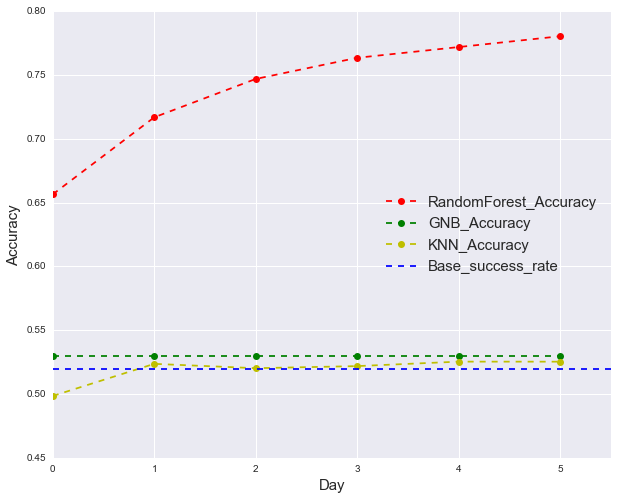

In [21]:
x_day_knn = []
y_day_knn = []
x_day_gnb = []
y_day_gnb = []
y_day_list = []
x_day_list = []

# RandomForest
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)

# Gaussian Naive Bayes
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_gnb = cross_val_score(gnb, x_classification_day, y, cv = Stkfold).mean()
    x_day_gnb.append(i)
    y_day_gnb.append(day_score_gnb)

# K-Nearest Neighbor
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_knn = cross_val_score(knn, x_classification_day, y, cv = Stkfold).mean()
    x_day_knn.append(i)
    y_day_knn.append(day_score_knn)

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'RandomForest_Accuracy');
plt.plot(x_day_gnb, y_day_gnb, 'o--', c = 'g', label = 'GNB_Accuracy');
plt.plot(x_day_knn, y_day_knn, 'o--', c = 'y', label = 'KNN_Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.xlim(0,5.5);

너무 낮은 GNB와 KNN Score -> model별 grid search 실시

***KNN gridsearch***

In [22]:
knn = KNeighborsClassifier()
#grid search
param_grid = [{'weights': ['uniform', 'distance'],
               'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
               'n_neighbors': [5, 10, 20, 30, 40, 50]}]

# run grid search
grid_search = GridSearchCV(knn, param_grid=param_grid)
start = time
grid_search.fit(x_classification_1day, y)

#print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
#      % ((time() - start), len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.560 (std: 0.012)
Parameters: {'algorithm': 'brute', 'weights': 'uniform', 'n_neighbors': 30}

Model with rank: 2
Mean validation score: 0.559 (std: 0.010)
Parameters: {'algorithm': 'auto', 'weights': 'uniform', 'n_neighbors': 30}

Model with rank: 3
Mean validation score: 0.559 (std: 0.015)
Parameters: {'algorithm': 'auto', 'weights': 'uniform', 'n_neighbors': 50}



***GNB grid search -> parameter 조정이 필요없음***

**#Grid search 결과, 낮은 score의 원인은 parameter selection 문제가 아니라 feature selection 문제이다.**

* **3 Features (without date_duration)**

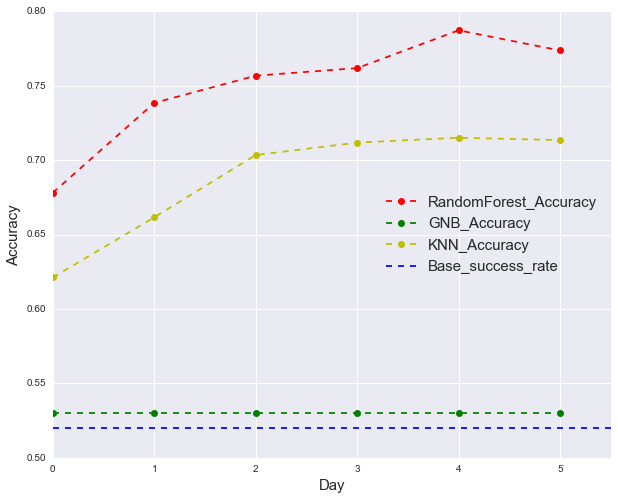

In [23]:
# 3 features (no duration)
x_day_knn = []
y_day_knn = []
x_day_gnb = []
y_day_gnb = []
y_day_list = []
x_day_list = []

# RandomForest
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['provider_grammar_level'], 
                                          wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)

# Gaussian Naive Bayes
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'],wadiz_df['provider_grammar_level'], 
                                          wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_gnb = cross_val_score(gnb, x_classification_day, y, cv = Stkfold).mean()
    x_day_gnb.append(i)
    y_day_gnb.append(day_score_gnb)

# K-Nearest Neighbor
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['provider_grammar_level'], 
                                          wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_knn = cross_val_score(knn, x_classification_day, y, cv = Stkfold).mean()
    x_day_knn.append(i)
    y_day_knn.append(day_score_knn)

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'RandomForest_Accuracy');
plt.plot(x_day_gnb, y_day_gnb, 'o--', c = 'g', label = 'GNB_Accuracy');
plt.plot(x_day_knn, y_day_knn, 'o--', c = 'y', label = 'KNN_Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.xlim(0,5.5);

**# KNN의 경우에는 score 증가, GNB는 변화없음 
-> date_duration은 KNN 모델에서 왜곡을 가져옴**

* 3 Features (without grammar_level)

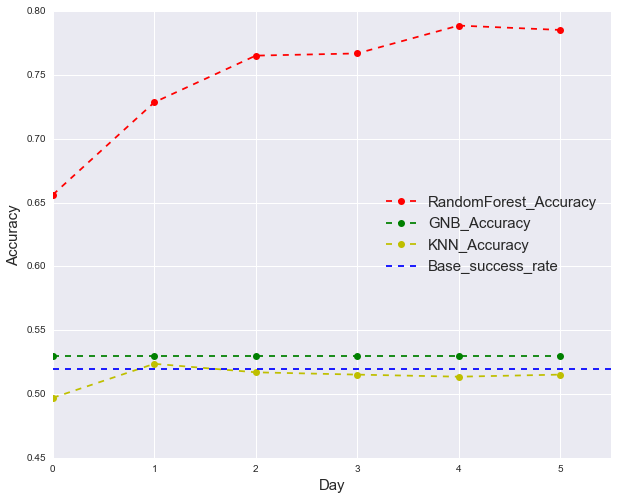

In [24]:
# 3 features (no grammar_level)

x_day_knn = []
y_day_knn = []
x_day_gnb = []
y_day_gnb = []
y_day_list = []
x_day_list = []

# RandomForest
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)

# Gaussian Naive Bayes
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_gnb = cross_val_score(gnb, x_classification_day, y, cv = Stkfold).mean()
    x_day_gnb.append(i)
    y_day_gnb.append(day_score_gnb)

# K-Nearest Neighbor
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_knn = cross_val_score(knn, x_classification_day, y, cv = Stkfold).mean()
    x_day_knn.append(i)
    y_day_knn.append(day_score_knn)

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'RandomForest_Accuracy');
plt.plot(x_day_gnb, y_day_gnb, 'o--', c = 'g', label = 'GNB_Accuracy');
plt.plot(x_day_knn, y_day_knn, 'o--', c = 'y', label = 'KNN_Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.xlim(0,5.5);

** # Score 변화없음 **

* 3 Features (without target)

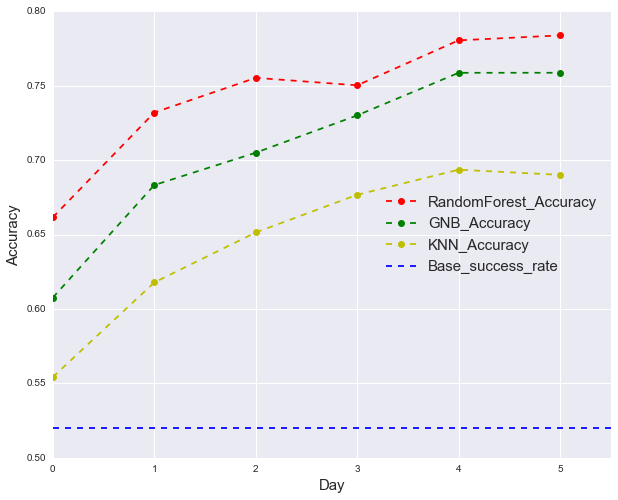

In [25]:
# no target
x_day_knn = []
y_day_knn = []
x_day_gnb = []
y_day_gnb = []
y_day_list = []
x_day_list = []

# RandomForest
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)

# Gaussian Naive Bayes
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_gnb = cross_val_score(gnb, x_classification_day, y, cv = Stkfold).mean()
    x_day_gnb.append(i)
    y_day_gnb.append(day_score_gnb)

# K-Nearest Neighbor
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_knn = cross_val_score(knn, x_classification_day, y, cv = Stkfold).mean()
    x_day_knn.append(i)
    y_day_knn.append(day_score_knn)

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'RandomForest_Accuracy');
plt.plot(x_day_gnb, y_day_gnb, 'o--', c = 'g', label = 'GNB_Accuracy');
plt.plot(x_day_knn, y_day_knn, 'o--', c = 'y', label = 'KNN_Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.xlim(0,5.5);

** # KNN, GNB 모델에서 Score 증가 **

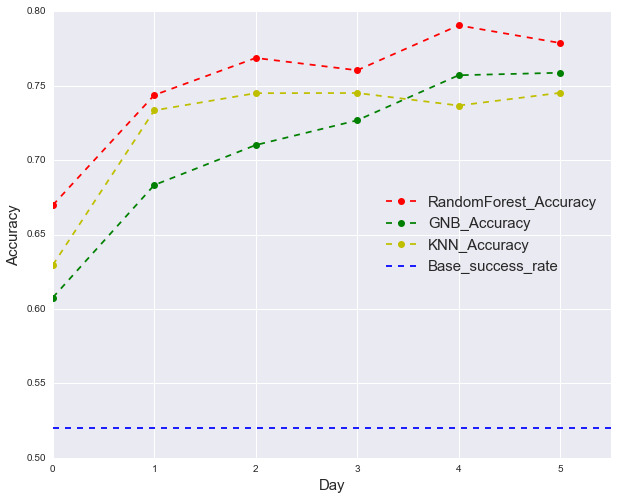

In [26]:
# no target, no duration
x_day_knn = []
y_day_knn = []
x_day_gnb = []
y_day_gnb = []
y_day_list = []
x_day_list = []

# RandomForest
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)

# Gaussian Naive Bayes
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_gnb = cross_val_score(gnb, x_classification_day, y, cv = Stkfold).mean()
    x_day_gnb.append(i)
    y_day_gnb.append(day_score_gnb)

# K-Nearest Neighbor
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    day_score_knn = cross_val_score(knn, x_classification_day, y, cv = Stkfold).mean()
    x_day_knn.append(i)
    y_day_knn.append(day_score_knn)

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'RandomForest_Accuracy');
plt.plot(x_day_gnb, y_day_gnb, 'o--', c = 'g', label = 'GNB_Accuracy');
plt.plot(x_day_knn, y_day_knn, 'o--', c = 'y', label = 'KNN_Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.xlim(0,5.5);

** Random Forest with 4 features vs GNB with 1 feature vs KNN with 1 feature**

Features_RandomForest : target, date_duration, grammar_level, (0~5)unding_rate

Features_GNB & KNN : (0~5)unding_rate


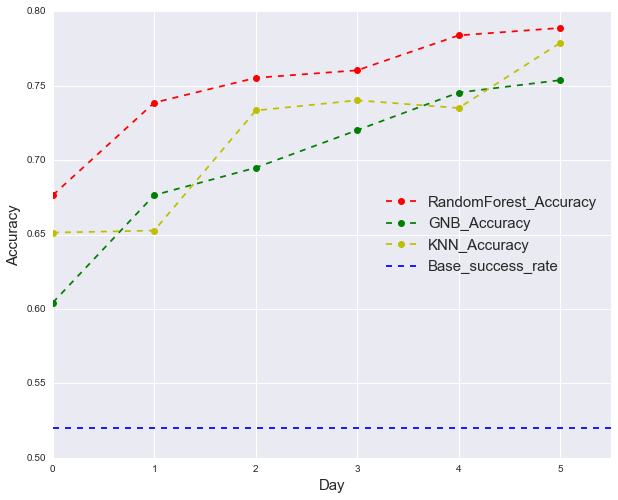

In [27]:
x_day_knn = []
y_day_knn = []
x_day_gnb = []
y_day_gnb = []
y_day_list = []
x_day_list = []


# RandomForest
for i in range(0, 6):
    x_classification_day =  pd.DataFrame([wadiz_df['target'], wadiz_df['date_duration'],
                                      wadiz_df['provider_grammar_level'], wadiz_df['{number}day_funding_rate'.format(number=i)]]).T
    score_cv = cross_val_score(best_re_day, x_classification_day, y, cv=Stkfold)
    score_cv_mean = score_cv.mean()
    score_cv_std = score_cv.std()
    y_day_list.append(score_cv_mean)
    x_day_list.append(i)

# Gaussian Naive Bayes
for i in range(0, 6):
    x_only_day_gnb = patsy.dmatrix(wadiz_df['{number}day_funding_rate'.format(number = i)])
    day_score_gnb = cross_val_score(gnb, x_only_day_gnb, y, cv = Stkfold).mean()
    x_day_gnb.append(i)
    y_day_gnb.append(day_score_gnb)

# K-Nearest Neighbor
for i in range(0, 6):
    x_only_day_knn = patsy.dmatrix(wadiz_df['{number}day_funding_rate'.format(number = i)])
    day_score_knn = cross_val_score(knn, x_only_day_knn, y, cv = Stkfold).mean()
    x_day_knn.append(i)
    y_day_knn.append(day_score_knn)

figure = plt.figure(figsize=(10,8))
plt.plot(x_day_list, y_day_list, 'o--', c = 'r', label = 'RandomForest_Accuracy');
plt.plot(x_day_gnb, y_day_gnb, 'o--', c = 'g', label = 'GNB_Accuracy');
plt.plot(x_day_knn, y_day_knn, 'o--', c = 'y', label = 'KNN_Accuracy');
plt.axhline(base_success_rate, ls = '--', label = 'Base_success_rate');
plt.legend(fontsize=15, loc=7);
plt.xlabel('Day', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.xlim(0,5.5);

### Distribution Test 결과들을 다시 생각해보자

성공/실패 target 분포에 대한 차이 검정

In [28]:
success_target = wadiz_df.loc[wadiz_df['success'] == 1]['target']
fail_target = wadiz_df.loc[wadiz_df['success'] == 0]['target']
print(sp.stats.ks_2samp(success_target, fail_target))

Ks_2sampResult(statistic=0.099283578721723942, pvalue=0.10013782598635514)


성공/실패 date_duration 분포에 대한 차이 검정

In [29]:
success_duration = wadiz_df.loc[wadiz_df['success'] == 1]['date_duration']
fail_duration = wadiz_df.loc[wadiz_df['success'] == 0]['date_duration']
print('[success_duration vs fail_duration]'), 
print(sp.stats.ks_2samp(success_duration, fail_duration))

[success_duration vs fail_duration]
Ks_2sampResult(statistic=0.10977604783663342, pvalue=0.051436259213459096)


* *두 feature 모두 성공/실패 class에서는 같은 분포를 이룬다.*

## 3. Result
* Best Model : Random Forest
* RandomForest 결과
    - funding 시작 당일 성공율 : 65.65%
    - 1일 후 : 72.86%
    - 2일 후 : 75.71%
    - 3일 후 : 75.03%
    - 4일 후 : 78.55%
    - 5일 후 : 80.06%


* Binary Class 문제에서 같은 분포를 이루는 feature들은 KNN, GaussianNB 모델에서 정확도를 크게 떨어트린다.
* 결국 모든 model에서 가장 큰 영향을 미치는 것은 day_funding_rate이다.
* day_funding_rate는 그 자체로 아주 많은 정보를 지니고있기 때문이다.
* 이런 결과들은 Funding이 시작된 이후 어떤 project들이 성공을 할 것인지 5일 이내에 각 날짜별로 예측을한 뒤 마케팅 전략을 수립할 때 도움이 될 것임.